In [99]:
import os
import time
import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
import plotly
from plotly import tools

import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go

pd.options.display.max_columns = 100

# read data
### have a look at the samples

In [100]:
file_dir = "transient_timeDomain_cut/"
sample_name = "1"
suffix = ".csv"
file_name = file_dir  + sample_name + suffix
sample_df = pd.read_csv(file_name)
print(sample_df.shape)
sample_df.head()

(1024, 4)


,gateSignalVoltage,gateEmitterVoltage,collectorEmitterVoltage,collectorEmitterCurrentSingal
0,8.828125,9.375000,4.5000,0.000000
1,7.968750,9.140625,4.5000,0.000000
2,6.796875,8.828125,4.4375,0.000000
3,5.546875,8.515625,4.3750,-0.015625
4,4.375000,8.437500,4.2500,0.000000


# expand timedomain cols
### P =mult(Vce, Vge), diff(Vce),diff(P), del Ice

In [101]:
all_df = all_df.drop("collectorEmitterCurrentSingal",axis = 1)
all_df["P"] = all_df["gateEmitterVoltage"]*all_df["collectorEmitterVoltage"]
all_df["P_diff"] = all_df["P"].diff()
all_df["gateEmitterVoltage_diff"] = all_df["gateEmitterVoltage"].diff()
all_df.fillna(method = "backfill",inplace = True)
all_df.head()

KeyError: "['collectorEmitterCurrentSingal'] not found in axis"

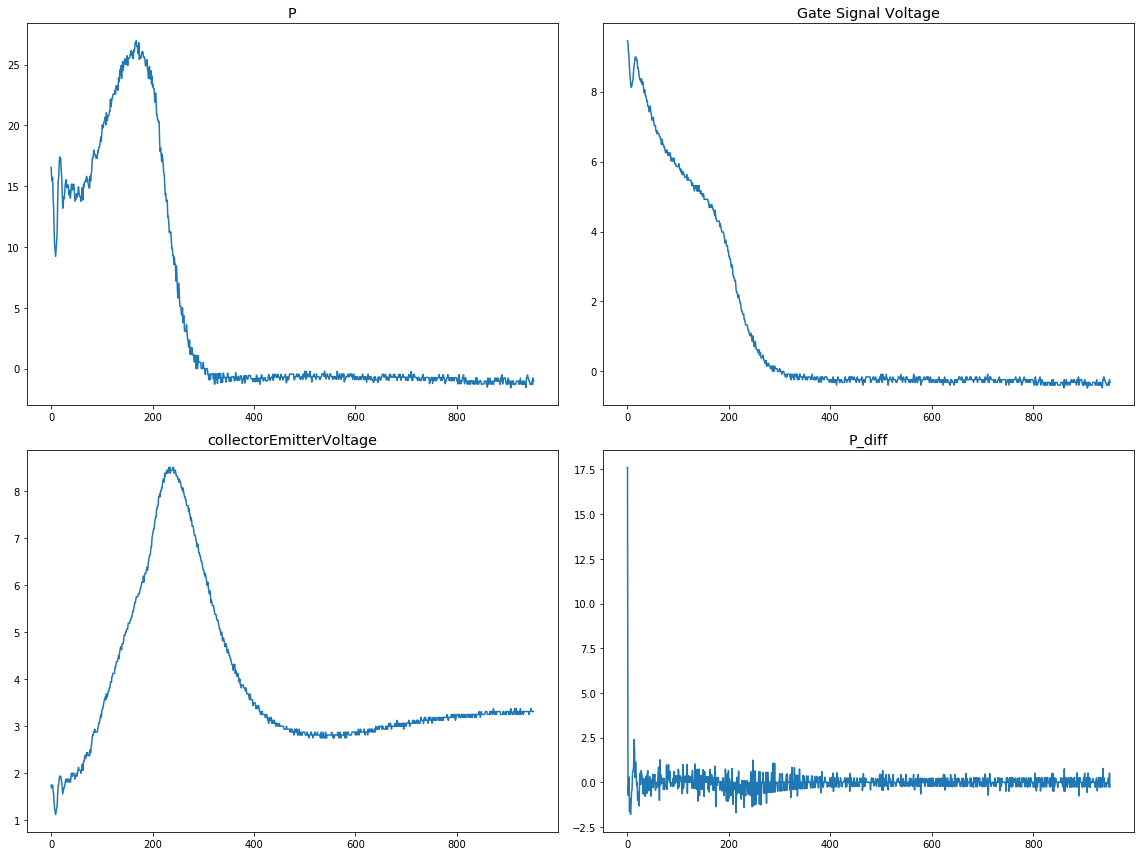

In [19]:
plt.figure(figsize=(16, 12))
plt.subplot(221)
plt.plot(all_df.index.values[2048:3000], all_df.P.values[2048:3000])
plt.title('P',fontsize ='x-large' )

plt.subplot(222)
plt.plot(all_df.index.values[2048:3000], all_df.gateEmitterVoltage.values[2048:3000])
plt.title('Gate Signal Voltage',fontsize ='x-large' )

plt.subplot(223)
plt.plot(all_df.index.values[2048:3000], all_df.collectorEmitterVoltage.values[2048:3000])
plt.title('collectorEmitterVoltage',fontsize ='x-large' )

plt.subplot(224)
plt.plot(all_df.index.values[2048:3000], all_df.P_diff.values[2048:3000])
plt.title('P_diff',fontsize ='x-large' )

plt.tight_layout()

# concat samples to one sumary data

In [21]:
all_df = pd.DataFrame()
for (_ ,_ , process_files) in os.walk('transient_timeDomain_cut'):
    for file in process_files:
        sample_df = pd.read_csv('transient_timeDomain_cut\\'+ file )
        
#         expand timedomain cols
        sample_df = sample_df.drop("collectorEmitterCurrentSingal",axis = 1)
        sample_df["P"] = sample_df["gateEmitterVoltage"]*sample_df["collectorEmitterVoltage"]
        sample_df["P_diff"] = sample_df["P"].diff()
        sample_df["gateEmitterVoltage_diff"] = sample_df["gateEmitterVoltage"].diff()
        sample_df.fillna(method = "backfill",inplace = True)

        try:
            round_num = int(file[:-4])
            sample_df['round_num'] = round_num
        except:
            sample_df['round_num'] = 0                
        all_df = pd.concat([all_df,sample_df])
        
all_df.to_csv('temp/all_transient_timeDomain_cut_expand.csv', index  = False)

# extract time domain features

In [23]:
train_df = all_df
train_df.head()

,gateSignalVoltage,gateEmitterVoltage,collectorEmitterVoltage,P,P_diff,gateEmitterVoltage_diff,round_num
0,8.828125,9.375000,4.5000,42.187501,-1.054688,-0.234375,1
1,7.968750,9.140625,4.5000,41.132813,-1.054688,-0.234375,1
2,6.796875,8.828125,4.4375,39.174805,-1.958008,-0.312500,1
3,5.546875,8.515625,4.3750,37.255860,-1.918945,-0.312500,1
4,4.375000,8.437500,4.2500,35.859376,-1.396484,-0.078125,1


In [26]:
statistic_values = ['max','min','mean','std']
agg_input = {}
for col in train_df.columns.values:
    agg_input[col] = statistic_values
    
agg_input.pop('round_num') 
agg_input.pop('gateSignalVoltage') 
agg_input.pop('gateEmitterVoltage_diff') 

agg_train_df = train_df.groupby('round_num').agg(agg_input)
agg_train_df.columns = ['_'.join(col).strip() for col in agg_train_df.columns.values ]
agg_train_df.reset_index(inplace = True)
agg_train_df.to_csv('temp\Expand_Features_agg_tem.csv',index = False)
print(agg_train_df.shape)
agg_train_df.head()

(418, 17)


,round_num,gateEmitterVoltage_max,gateEmitterVoltage_min,gateEmitterVoltage_mean,gateEmitterVoltage_std,collectorEmitterVoltage_max,collectorEmitterVoltage_min,collectorEmitterVoltage_mean,collectorEmitterVoltage_std,P_max,P_min,P_mean,P_std,P_diff_max,P_diff_min,P_diff_mean,P_diff_std
0,1,9.37500,-0.546875,1.100921,2.804420,11.937499,-3.624999,1.420594,3.618654,74.609371,-5.493162,9.072389,20.163854,2.797852,-4.648437,-0.042143,0.645866
1,2,9.37500,-0.625000,1.076736,2.733513,25.468751,1.249999,4.896240,3.942578,65.185548,-2.343751,6.181704,15.077502,4.150391,-5.761719,-0.021505,0.781727
2,3,9.68750,-0.546875,1.102066,2.719779,21.250001,1.249999,4.751739,3.461617,55.664062,-2.307130,5.849980,13.746630,3.454590,-3.271485,-0.022173,0.657966
3,4,9.53125,-0.546875,1.105194,2.700340,18.593751,1.249999,4.640197,3.165021,48.339844,-2.050782,5.585204,12.877810,3.210449,-4.577637,-0.020456,0.697114
4,5,9.37500,-0.468750,1.099014,2.676407,11.937499,1.437500,4.475830,2.304245,43.124996,-1.875001,5.220264,11.973446,1.865234,-2.333984,-0.020423,0.455081


In [30]:
tempareture_df = pd.read_csv("collectorEmitterVoltage_peak_temperature.csv")
agg_train_df["temperature"] = tempareture_df["tempareture"]
agg_train_df.to_csv('temp\Expand_Features_agg_temperature.csv',index = False)
print(agg_train_df.shape)
agg_train_df.head()

(418, 18)


,round_num,gateEmitterVoltage_max,gateEmitterVoltage_min,gateEmitterVoltage_mean,gateEmitterVoltage_std,collectorEmitterVoltage_max,collectorEmitterVoltage_min,collectorEmitterVoltage_mean,collectorEmitterVoltage_std,P_max,P_min,P_mean,P_std,P_diff_max,P_diff_min,P_diff_mean,P_diff_std,temperature
0,1,9.37500,-0.546875,1.100921,2.804420,11.937499,-3.624999,1.420594,3.618654,74.609371,-5.493162,9.072389,20.163854,2.797852,-4.648437,-0.042143,0.645866,47.211104
1,2,9.37500,-0.625000,1.076736,2.733513,25.468751,1.249999,4.896240,3.942578,65.185548,-2.343751,6.181704,15.077502,4.150391,-5.761719,-0.021505,0.781727,124.804264
2,3,9.68750,-0.546875,1.102066,2.719779,21.250001,1.249999,4.751739,3.461617,55.664062,-2.307130,5.849980,13.746630,3.454590,-3.271485,-0.022173,0.657966,178.408544
3,4,9.53125,-0.546875,1.105194,2.700340,18.593751,1.249999,4.640197,3.165021,48.339844,-2.050782,5.585204,12.877810,3.210449,-4.577637,-0.020456,0.697114,215.428544
4,5,9.37500,-0.468750,1.099014,2.676407,11.937499,1.437500,4.475830,2.304245,43.124996,-1.875001,5.220264,11.973446,1.865234,-2.333984,-0.020423,0.455081,244.451166


# delete outliners

In [103]:
round_num_del = [1,2,3,4,5,6,7,8,9,10,11,12,13,24,35,46,112,223,334,386,375,364]
round_num_del = [i-1 for i in round_num_del]
agg_train_df = pd.read_csv('temp\Expand_Features_agg_temperature.csv')
agg_train_df.drop(round_num_del,axis = 0,inplace = True)
agg_train_df.to_csv('temp\Expand_Features_agg_temperature_outliners.csv',index = False)
agg_train_df.head()


,round_num,gateEmitterVoltage_max,gateEmitterVoltage_min,gateEmitterVoltage_mean,gateEmitterVoltage_std,collectorEmitterVoltage_max,collectorEmitterVoltage_min,collectorEmitterVoltage_mean,collectorEmitterVoltage_std,P_max,P_min,P_mean,P_std,P_diff_max,P_diff_min,P_diff_mean,P_diff_std,temperature
13,14,9.296875,-0.46875,1.132431,2.609853,10.499999,1.0625,3.998047,1.933608,30.537108,-1.640626,4.481462,9.570787,2.021484,-2.431641,-0.018606,0.427725,324.270022
14,15,9.453125,-0.46875,1.135025,2.632806,10.562499,1.1250,3.998169,1.931543,30.825194,-1.640626,4.479946,9.634211,2.270508,-2.138672,-0.017490,0.398493,322.699037
15,16,9.375000,-0.46875,1.111603,2.613160,10.249999,1.1250,3.996887,1.884936,29.296874,-1.640626,4.348201,9.443815,1.865234,-2.329102,-0.018458,0.413458,325.316266
16,17,9.531250,-0.46875,1.123886,2.607567,9.937499,1.1250,3.996948,1.813141,28.593749,-1.640626,4.347481,9.319452,1.923828,-2.299805,-0.018196,0.401001,329.912613
17,18,9.375000,-0.46875,1.091003,2.604231,10.249999,1.1875,3.991272,1.862889,28.945311,-1.640626,4.247231,9.353139,1.889648,-1.816406,-0.018768,0.400898,327.237079


## plot all features

In [104]:

plt.figure(figsize=(12, 6))
# plt.figure()
# plt.plot(train_df.round_num.values ,train_df.torque_drive_07_kurt.values)
for col in agg_train_df.columns:
    plt.plot(agg_train_df.round_num.values[10:] ,agg_train_df[col].values[10:])
    plt.title(col,fontsize = 'x-large')
    plt.tight_layout()
    plt.savefig('temp/'+col+'.png')
    plt.clf()

<Figure size 864x432 with 0 Axes>

In [ ]:
collectorEmitterVoltage_peak_temperature

# calculate correlationship and IM

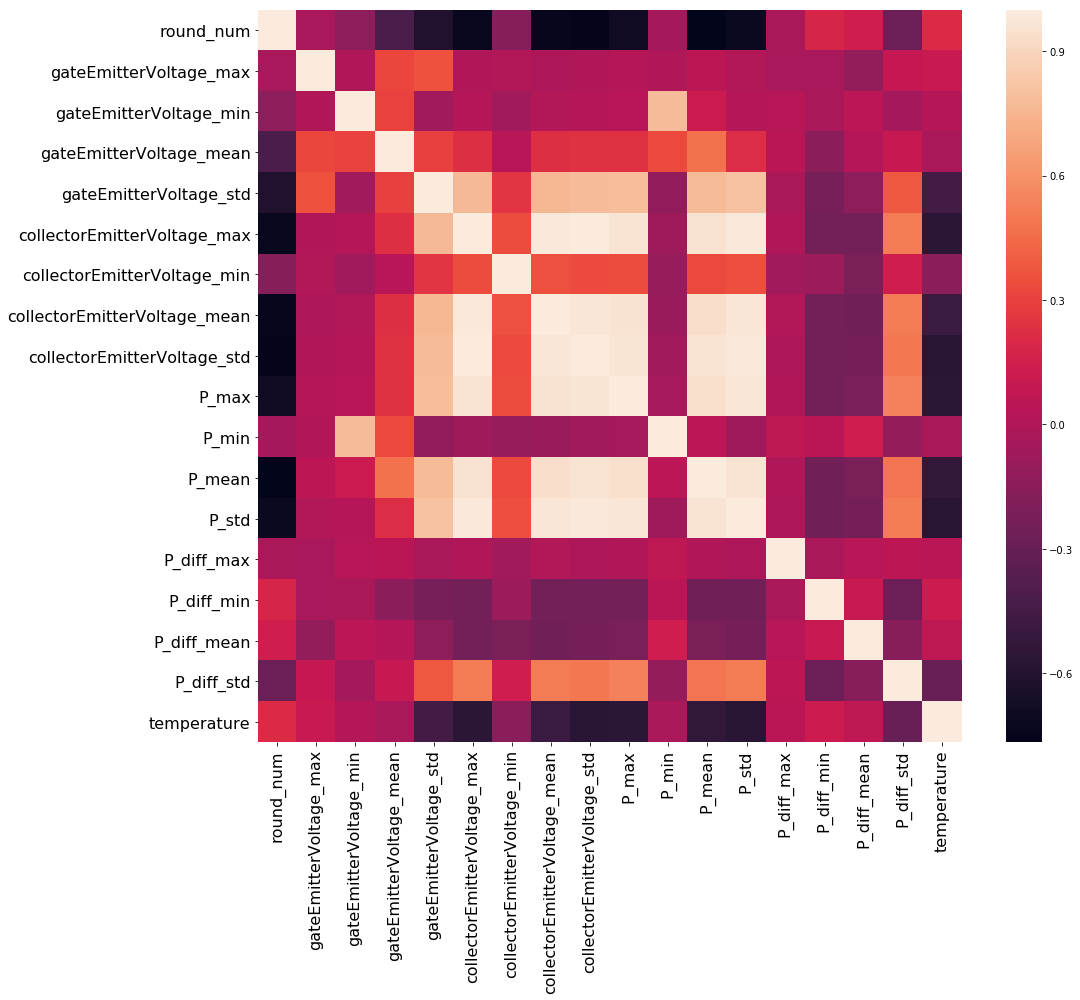

In [105]:
corr_df = agg_train_df.corr()
corr_df.to_csv("temp/coelationship_outliners.csv")
plt.figure(figsize=(16,14))
sns.heatmap(corr_df)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('temp/correlationship_outliners'+'.png')

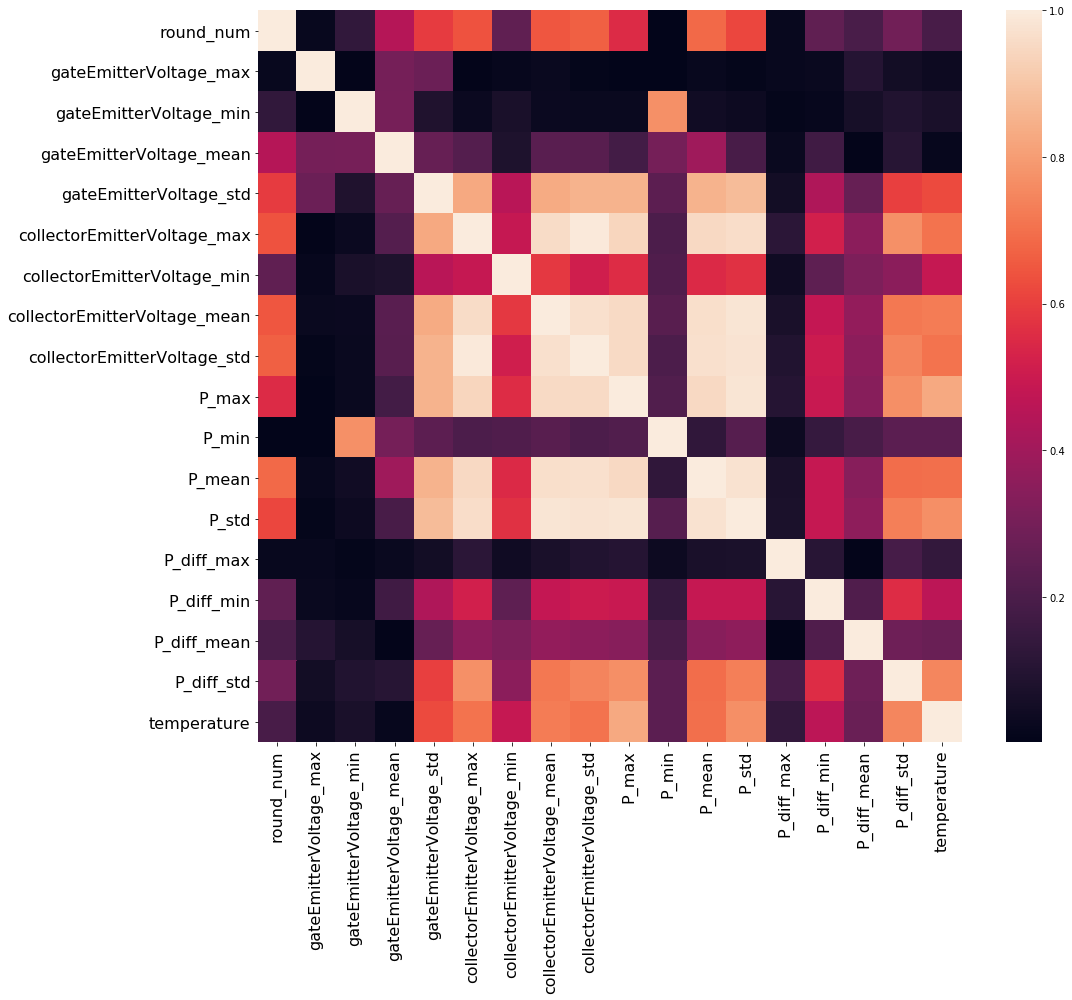

In [64]:
corr_df_abs = abs(corr_df)
corr_df_abs.to_csv("temp/coelationship_abs_outliners.csv")
plt.figure(figsize=(16,14))
sns.heatmap(corr_df_abs)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('temp/correlationship_abs_outliners'+'.png')

Index(['round_num', 'P_mean', 'collectorEmitterVoltage_std',
       'collectorEmitterVoltage_mean', 'collectorEmitterVoltage_max', 'P_std',
       'gateEmitterVoltage_std', 'P_max', 'gateEmitterVoltage_mean',
       'P_diff_std', 'collectorEmitterVoltage_min', 'P_diff_min',
       'P_diff_mean', 'temperature', 'gateEmitterVoltage_min', 'P_diff_max',
       'gateEmitterVoltage_max', 'P_min'],
      dtype='object')


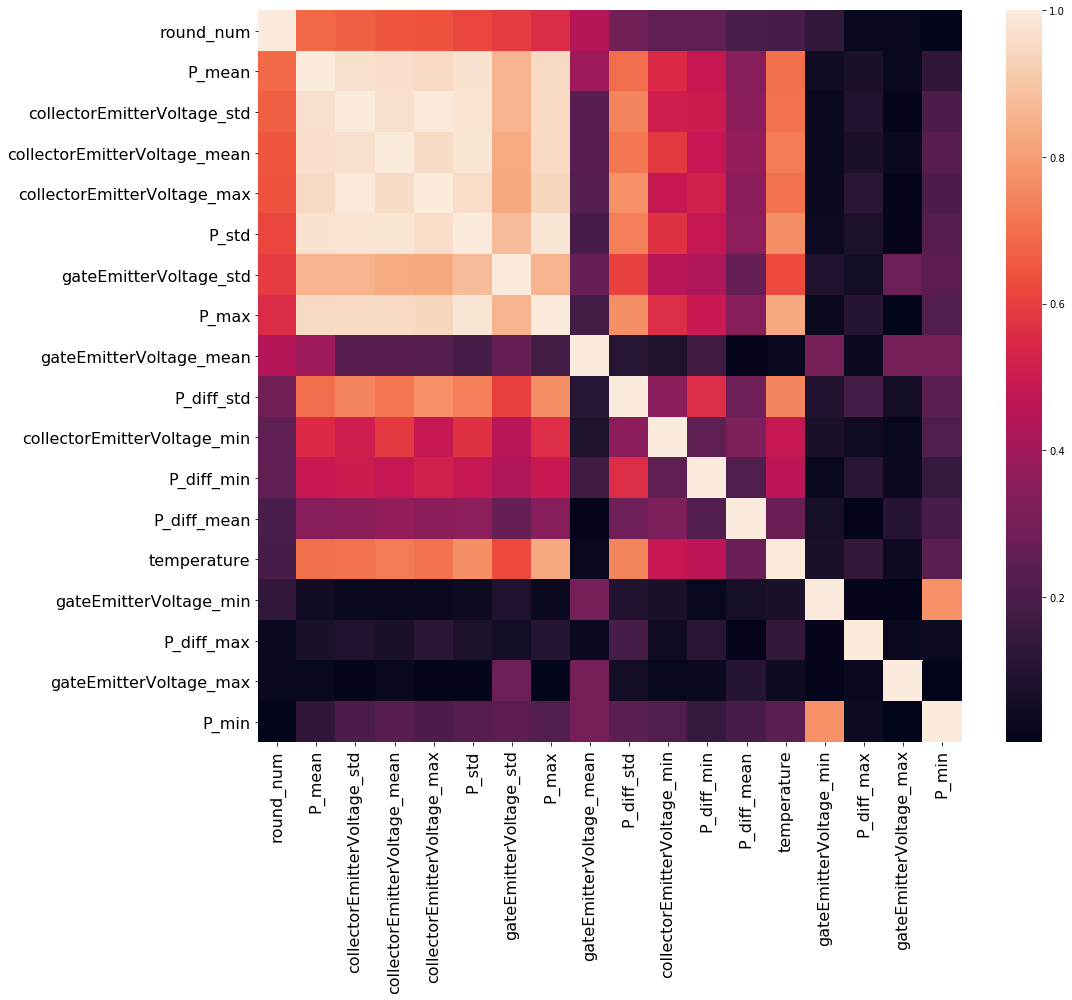

In [106]:
corr_df_abs_sort = corr_df_abs.sort_values(by = "round_num",axis = 0, ascending = False, inplace = False)
corr_df_abs_sort = corr_df_abs_sort.sort_values(by = "round_num",axis = 1, ascending = False, inplace = False)
corr_df_abs_sort.to_csv("temp/coelationship_abs_sort_outliners.csv")
plt.figure(figsize=(16,14))
sns.heatmap(corr_df_abs_sort)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('temp/correlationship_abs_sort_outliners'+'.png')
print(corr_df_abs_sort.columns)

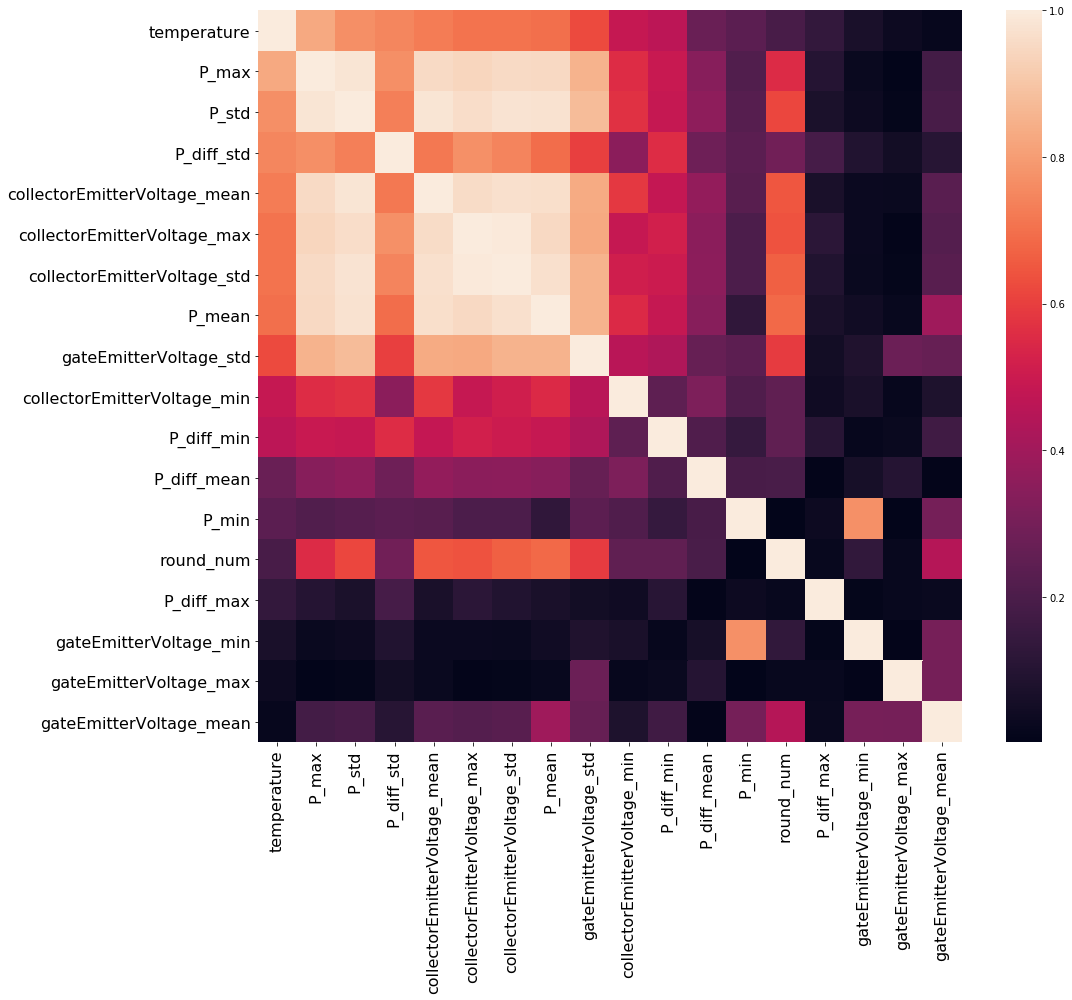

In [66]:
corr_df_abs_sort = corr_df_abs.sort_values(by = "temperature",axis = 0, ascending = False, inplace = False)
corr_df_abs_sort = corr_df_abs_sort.sort_values(by = "temperature",axis = 1, ascending = False, inplace = False)
plt.figure(figsize=(16,14))
sns.heatmap(corr_df_abs_sort)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('temp/correlationship_abs_sortby_temperature_outliners'+'.png')

## col xcorr

In [84]:
def xcorr(df, col1, col2):
    return np.correlate(agg_train_df[col1].values,agg_train_df[col2].values)/np.sqrt(np.correlate(agg_train_df[col1].values,agg_train_df[col1].values)*np.correlate(agg_train_df[col2].values,agg_train_df[col2].values))


In [90]:
agg_train_df = pd.read_csv("temp/Expand_Features_agg_temperature_outliners.csv")
cols = agg_train_df.columns.values
xcorr_df = pd.DataFrame(columns = cols,index = cols)
for col1 in cols:
    for col2 in cols:
        xcorr_df[col1][col2] = xcorr(agg_train_df, col1, col2)[0]
        
xcorr_df.fillna(0,inplace = True)
xcorr_df.head()

,round_num,gateEmitterVoltage_max,gateEmitterVoltage_min,gateEmitterVoltage_mean,gateEmitterVoltage_std,collectorEmitterVoltage_max,collectorEmitterVoltage_min,collectorEmitterVoltage_mean,collectorEmitterVoltage_std,P_max,P_min,P_mean,P_std,P_diff_max,P_diff_min,P_diff_mean,P_diff_std,temperature
round_num,1.000000,0.871675,-0.874180,0.869484,0.870288,0.834682,0.866804,0.863323,0.836043,0.849151,-0.869669,0.855377,0.855323,0.862817,-0.845463,-0.866059,0.862987,0.873815
gateEmitterVoltage_max,0.871675,1.000000,-0.997080,0.999929,0.999954,0.994558,0.999278,0.999610,0.995242,0.997164,-0.997332,0.998899,0.998652,0.991391,-0.989692,-0.998772,0.998571,0.999676
gateEmitterVoltage_min,-0.874180,-0.997080,1.000000,-0.996825,-0.997143,-0.991984,-0.996649,-0.996844,-0.992624,-0.994484,0.998745,-0.995902,-0.995962,-0.988514,0.987071,0.996129,-0.996077,-0.996713
gateEmitterVoltage_mean,0.869484,0.999929,-0.996825,1.000000,0.999946,0.994801,0.999307,0.999672,0.995478,0.997298,-0.997095,0.999072,0.998750,0.991446,-0.989902,-0.998718,0.998594,0.999655
gateEmitterVoltage_std,0.870288,0.999954,-0.997143,0.999946,1.000000,0.995053,0.999405,0.999764,0.995719,0.997534,-0.997457,0.999127,0.998924,0.991485,-0.990013,-0.998826,0.998744,0.999622


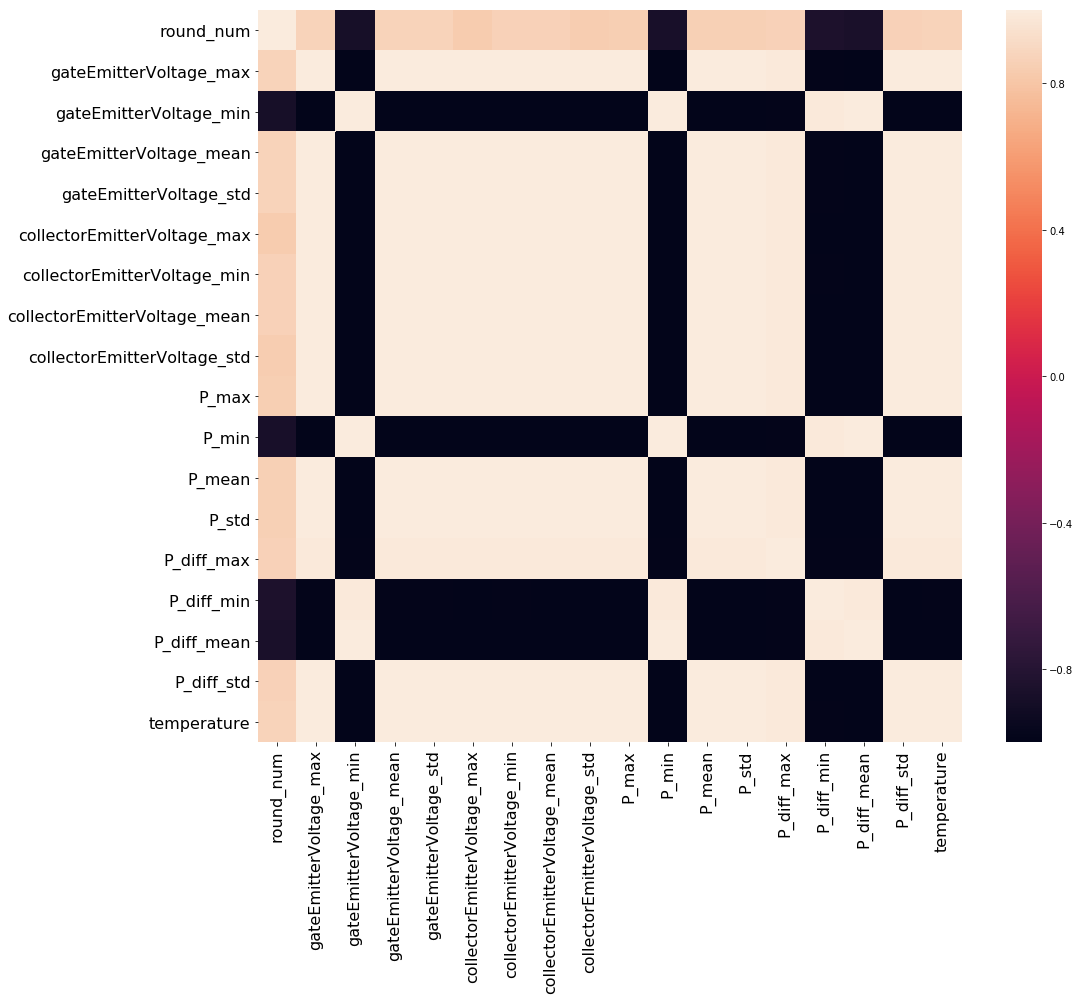

In [91]:
plt.figure(figsize=(16,14))
sns.heatmap(xcorr_df)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('temp/xcorr_df_outliners'+'.png')

# visualization

In [97]:
use_cols = ['P_mean', 'collectorEmitterVoltage_std', 'collectorEmitterVoltage_mean', 'collectorEmitterVoltage_max',
            'P_std', 'gateEmitterVoltage_std', 'P_max',
            'temperature',
            'round_num']
temp_relative = [ 'P_max','P_std','P_mean','P_diff_std','collectorEmitterVoltage_std','gateEmitterVoltage_std']

agg_train_df = pd.read_csv("temp/Expand_Features_agg_temperature_outliners.csv")
train_df  = agg_train_df[use_cols]
train_df[temp_relative] = agg_train_df[temp_relative]
train_df.to_csv("temp/train_df_addTempRelate.csv",index = False)
print(train_df.shape)
train_df.head()

(405, 10)


,P_mean,collectorEmitterVoltage_std,collectorEmitterVoltage_mean,collectorEmitterVoltage_max,P_std,gateEmitterVoltage_std,P_max,temperature,round_num,P_diff_std
0,5.585204,3.165021,4.640197,18.593751,12.877810,2.700340,48.339844,215.428544,4,0.697114
1,5.220264,2.304245,4.475830,11.937499,11.973446,2.676407,43.124996,244.451166,5,0.455081
2,5.116795,2.315193,4.431763,11.937499,11.519807,2.671716,39.531246,270.927857,6,0.470149
3,4.973592,2.303471,4.351562,11.937499,10.960853,2.648789,35.410154,293.838282,7,0.469470
4,4.323339,1.780973,4.027100,9.687499,9.041481,2.596341,27.470702,325.960856,8,0.416637


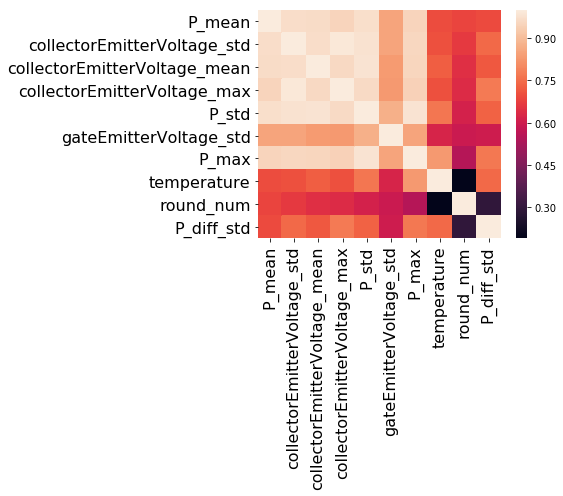

In [98]:
corr_df = abs(train_df.corr())
# corr_df.to_csv("temp/coelationship_train.csv")
plt.figure(figsize=(8,7))
sns.heatmap(corr_df)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
# plt.savefig('temp/coelationship_train'+'.png')